# DATA ANALYSIS

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk.sentiment.vader as vd
from nltk.tokenize import word_tokenize
from PIL import Image
from os import path, getcwd
import dataframe_image as dfi

In [2]:
with open("serialized/data.pkl", "rb") as f:
    data = pickle.load(f)

## 1. Frequencies

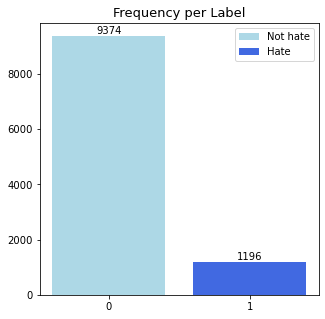

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
labels = data["label"].value_counts().values
rects1 = ax.bar("0", data["label"].value_counts().values[0], color=['lightblue'], label='Not hate')
rects2 = ax.bar("1", data["label"].value_counts().values[1], color=[ 'royalblue'], label='Hate')
rects = ax.patches
ax.legend()
#ax.tick_params(axis='both', colors='grey')
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')#.set_color("grey")
plt.title('Frequency per Label', fontsize = 13)#.set_color("grey")
fig.savefig("images_d\Freq_labels.png")

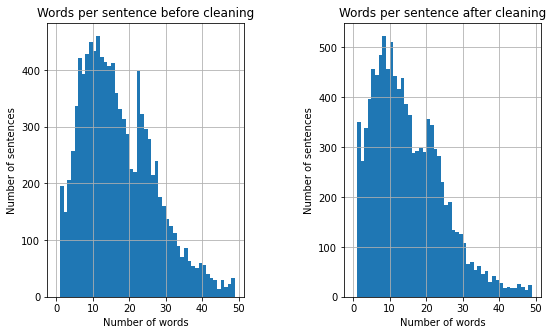

In [4]:
fig = plt.figure()
ax = plt.subplot(1,2,1)
#plt.figure(figsize=(10,5))
plt.hist(data.word_count_before.values, bins = range(0, 50))
plt.title('Words per sentence before cleaning')#.set_color("grey")
plt.xlabel("Number of words")#.set_color("grey")
plt.ylabel("Number of sentences")#.set_color("grey")
#ax.tick_params(axis='both', colors='grey')
plt.grid(True)

ax = plt.subplot(1,2,2)
plt.hist(data.word_count.values, bins = range(0, 50))
plt.title('Words per sentence after cleaning')#.set_color("grey")
plt.xlabel("Number of words")#.set_color("grey")
plt.ylabel("Number of sentences") #.set_color("grey")
#ax.tick_params(axis='both', colors='grey')
plt.grid(True)

plt.tight_layout(w_pad=3.5, h_pad=1.0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.savefig("images_d\Words_before_after.png")
plt.show()

## 2. Top words

In [5]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [6]:
common_words = get_top_n_words(data['text_clean'], 50)
cmw = {word: freq for word, freq in common_words}

In [7]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw[:20]

,words,freq
0,the,6650
1,to,4644
2,and,4258
3,of,3416
4,in,2807
5,is,2314
6,it,2124
7,that,1880
8,you,1794
9,are,1663


In [8]:
df_styled = mcw
dfi.export(df_styled,"images_d/top_words_df.jpg")

In [9]:
with open("serialized/mcw.pkl", "wb") as f:
    pickle.dump(mcw[:20], f)

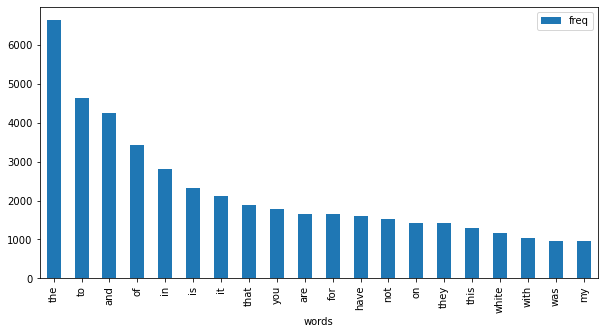

In [10]:
mcw = mcw[:20]
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5), width=0.5)
plt.savefig("images_d\Top20_words.png")
plt.show()

## 3.1 Part of Speech

In [11]:
all_pos = data['POS_spacy'].sum()

In [12]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]
all_propn = [x[0] for x in all_pos if x[1] == "PROPN"]
all_verbs = [x[0] for x in all_pos if x[1] == "VERB"]

In [13]:
hate = data.loc[data["label"] == 1]

In [14]:
all_pos_hate = hate['POS_spacy'].sum()

In [15]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]
all_propn_hate = [x[0] for x in all_pos_hate if x[1] == "PROPN"]
all_verbs_hate = [x[0] for x in all_pos_hate if x[1] == "VERB"]

In [16]:
no_hate = data.loc[data["label"] == 0]

In [17]:
all_pos_no_hate = no_hate['POS_spacy'].sum()

In [18]:
all_adjs_no_hate = [x[0] for x in all_pos_no_hate if x[1] == "ADJ"]
all_nouns_no_hate = [x[0] for x in all_pos_no_hate if x[1] == "NOUN"]
all_propn_no_hate = [x[0] for x in all_pos_no_hate if x[1] == "PROPN"]
all_verbs_no_hate = [x[0] for x in all_pos_no_hate if x[1] == "VERB"]

## 3.2 Top POS

In [19]:
pos_counter_no = {}
for x in all_pos_no_hate:
    if x[1] in pos_counter_no:
        pos_counter_no[x[1]] += 1
    else:
        pos_counter_no[x[1]] = 1
        
top_pos_no = {k: v for k, v in sorted(pos_counter_no.items(), key=lambda item: item[1], reverse=True)}

In [20]:
freq_pos_no = pd.DataFrame.from_dict(top_pos_no, orient="index", columns=["Freq"]).reset_index()
freq_pos_no["R_Freq"] = freq_pos_no.apply(lambda x: np.round(x.Freq / freq_pos_no.Freq.sum(), 2), axis=1)

In [21]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [22]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [23]:
compared_pos = {"No_Hate": list(top_pos_no.keys())[:len(top_pos_hate)], "Freq_No_Hate": list(top_pos_no.values())[:len(top_pos_hate)], "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_No_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_No_Hate / compared_pos.Freq_No_Hate.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['No_Hate', 'R_Freq_No_Hate', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos

,No_Hate,R_Freq_No_Hate,Hate_Speech,R_Freq_Hate
0,NOUN,0.194,NOUN,0.190
1,VERB,0.144,VERB,0.154
2,ADP,0.105,DET,0.106
3,DET,0.097,ADP,0.097
4,ADJ,0.085,ADJ,0.088
5,PROPN,0.073,PRON,0.073
6,PRON,0.067,ADV,0.065
7,AUX,0.067,AUX,0.064
8,ADV,0.066,PROPN,0.052
9,CCONJ,0.036,CCONJ,0.040


In [24]:
df_styled = compared_pos
dfi.export(df_styled,"images_d/top_pos_df.jpg")

In [25]:
with open("serialized/top_pos_df.pkl", "wb") as f:
    pickle.dump(compared_pos, f)

## 3.3 Top Adjectives

In [26]:
adj_counter_no = {}
for word in all_adjs_no_hate:
    if word in adj_counter_no:
        adj_counter_no[word] += 1
    else:
        adj_counter_no[word] = 1

top_20_adj_no = {k: v for k, v in sorted(adj_counter_no.items(), key=lambda item: item[1], reverse=True)[:20]}

In [27]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

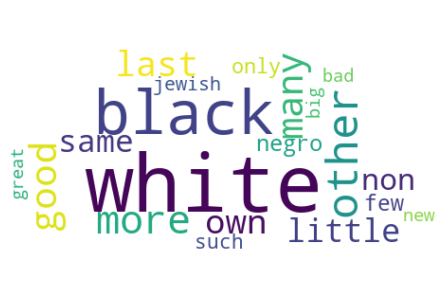

In [28]:
path_cloud = "C:/Users/marti/OneDrive - Università degli Studi di Milano/Desktop/Text mining before final version/images/aa.png"
cloud = np.array(Image.open(path_cloud))
wc_a_hate = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_adj1)
plt.figure(figsize=(8,5))
plt.imshow(wc_a_hate, interpolation="bilinear")
plt.axis("off")
wc_a_hate.to_file("images_d\wc_a_hate.png")
plt.show()

In [29]:
top_adj = {"No_Hate": top_20_adj_no.keys(), "Freq_No_Hate": top_20_adj_no.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_No_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_No_Hate / top_adj.Freq_No_Hate.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['No_Hate', 'R_Freq_No_Hate', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,No_Hate,R_Freq_No_Hate,Hate_Speech,R_Freq_Hate
0,white,0.214,white,0.264
1,good,0.083,black,0.138
2,black,0.065,other,0.060
3,other,0.062,more,0.051
4,few,0.058,good,0.047
5,more,0.055,many,0.046
6,new,0.054,last,0.042
7,many,0.050,own,0.039
8,old,0.046,little,0.034
9,same,0.042,same,0.032


In [30]:
df_styled = top_adj
dfi.export(df_styled,"images_d/top_adj_df.jpg")

In [31]:
with open("serialized/top_adj_df.pkl", "wb") as f:
    pickle.dump(top_adj, f)

In [32]:
common_adj = list(set(top_adj["Hate_Speech"].values).intersection(set(top_adj["No_Hate"].values)))

In [33]:
freq_common_no_adj = [adj_counter_no[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [34]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_No_Hate": freq_common_no_adj, "Freq_Hate_Speech": freq_common_hate_adj } )
common_adj_df = common_adj_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

In [35]:
with open("serialized/top20adj.pkl", "wb") as f:
    pickle.dump(common_adj_df, f)

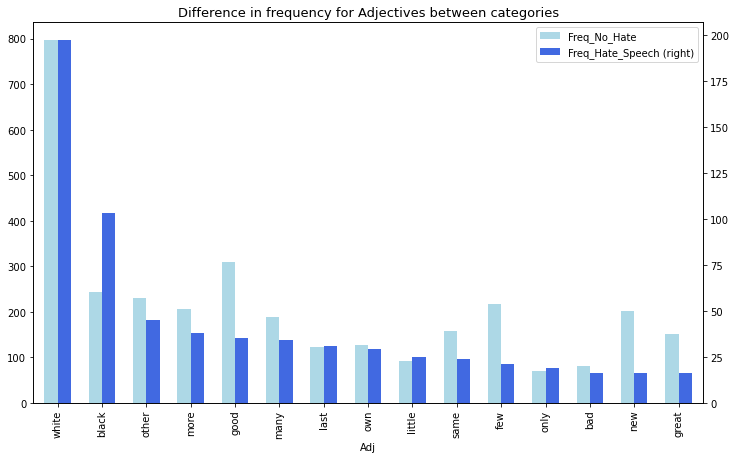

In [36]:
common_adj_df.set_index("Adj").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
#plt.grid(True)
plt.title('Difference in frequency for Adjectives between categories', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\Adj_tot_hate.png")
plt.show()

Difference in number of Adjectives is  0.5956998400899662


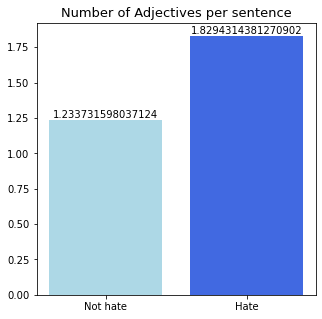

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (no_hate.ADJ_count.mean(), hate.ADJ_count.mean())
ax.bar("Not hate", no_hate.ADJ_count.mean(), color=['lightblue'], label='Not hate')
ax.bar("Hate", hate.ADJ_count.mean(), color=[ 'royalblue'], label='Hate')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Adjectives per sentence', fontsize = 13)
print('Difference in number of Adjectives is ', hate.ADJ_count.mean() - no_hate.ADJ_count.mean() )

## 3.4 Top Nouns

In [38]:
noun_counter_no = {}
for word in all_nouns_no_hate:
    if word in noun_counter_no:
        noun_counter_no[word] += 1
    else:
        noun_counter_no[word] = 1
            
top_20_noun_no = {k: v for k, v in sorted(noun_counter_no.items(), key=lambda item: item[1], reverse=True)[:20]}

In [39]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

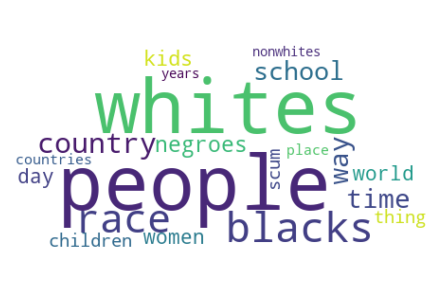

In [40]:
wc_n_hate = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_noun1)
plt.figure(figsize=(8,5))
plt.imshow(wc_n_hate, interpolation="bilinear")
plt.axis("off")
wc_n_hate.to_file("images_d\wc_n_hate.png")
plt.show()

In [41]:
top_noun = {"No_Hate": top_20_noun_no.keys(), "Freq_No_Hate": top_20_noun_no.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_No_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_No_Hate / top_noun.Freq_No_Hate.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['No_Hate', 'R_Freq_No_Hate', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,No_Hate,R_Freq_No_Hate,Hate_Speech,R_Freq_Hate
0,people,0.152,people,0.120
1,time,0.071,whites,0.117
2,school,0.066,blacks,0.097
3,whites,0.055,race,0.087
4,years,0.055,country,0.056
5,kids,0.053,time,0.049
6,year,0.052,way,0.049
7,day,0.050,school,0.045
8,way,0.050,negroes,0.043
9,video,0.047,kids,0.038


In [42]:
df_styled = top_noun
dfi.export(df_styled,"images_d/top_noun_df.jpg")

In [43]:
with open("serialized/top_noun_df.pkl", "wb") as f:
    pickle.dump(top_noun, f)

In [44]:
common_nouns = list(set(top_noun["Hate_Speech"].values).intersection(set(top_noun["No_Hate"].values)))

In [45]:
freq_common_noun_no = [noun_counter_no[x] for x in common_nouns]
freq_common_noun_hate = [noun_counter1[x] for x in common_nouns]

In [46]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_No_Hate": freq_common_noun_no, "Freq_Hate_Speech": freq_common_noun_hate })
common_noun_df = common_noun_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

In [47]:
with open("serialized/top20noun.pkl", "wb") as f:
    pickle.dump(common_noun_df, f)

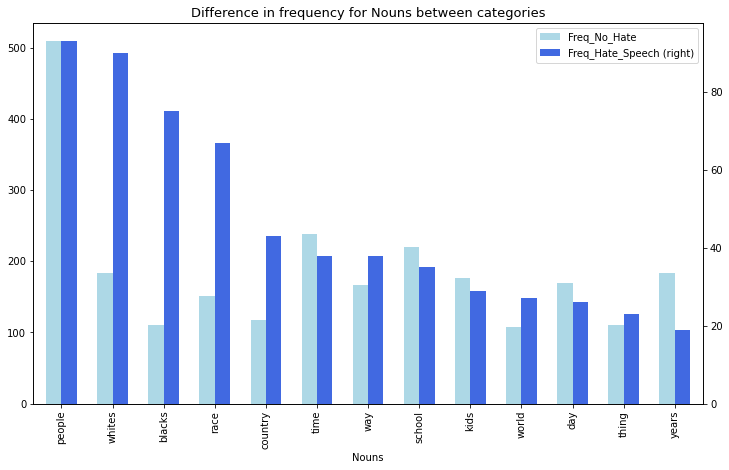

In [48]:
common_noun_df.set_index("Nouns").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
#plt.grid(True)
plt.title('Difference in frequency for Nouns between categories', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\ Noun_tot_hate.png")
plt.show()

Difference in number of nouns is  1.1459819482194042


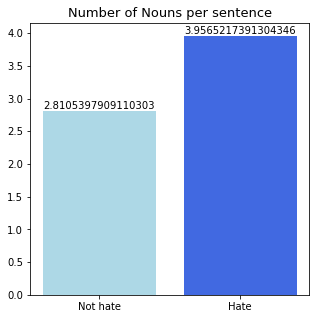

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (no_hate.NOUN_count.mean(), hate.NOUN_count.mean())
ax.bar("Not hate", no_hate.NOUN_count.mean(), color=['lightblue'], label='Not hate')
ax.bar("Hate", hate.NOUN_count.mean(), color=[ 'royalblue'], label='Hate')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Nouns per sentence', fontsize = 13)
print('Difference in number of nouns is ', hate.NOUN_count.mean() - no_hate.NOUN_count.mean() )

## 3.5 Top Proper Nouns

In [50]:
propn_counter_no = {}
for word in all_propn_no_hate:
    if word in propn_counter_no:
        propn_counter_no[word] += 1
    else:
        propn_counter_no[word] = 1

top_20_propn_no = {k: v for k, v in sorted(propn_counter_no.items(), key=lambda item: item[1], reverse=True)[:20]}

In [51]:
propn_counter1 = {}
for word in all_propn_hate:
    if word in propn_counter1:
        propn_counter1[word] += 1
    else:
        propn_counter1[word] = 1
            
top_20_propn1 = {k: v for k, v in sorted(propn_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

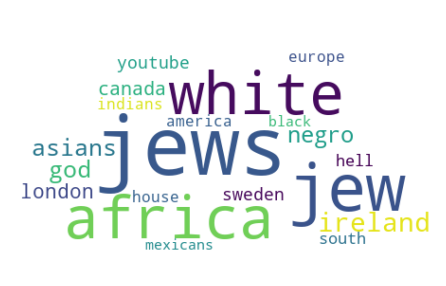

In [52]:
wc_p_hate = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_propn1)
plt.figure(figsize=(8,5))
plt.imshow(wc_p_hate, interpolation="bilinear")
plt.axis("off")
wc_p_hate.to_file("images_d\wc_p_hate.png")
plt.show()

In [53]:
top_propn = {"No_Hate": top_20_propn_no.keys(), "Freq_No_Hate": top_20_propn_no.values(), "Hate_Speech": top_20_propn1.keys(), "Freq_Hate": top_20_propn1.values()}
top_propn = pd.DataFrame(top_propn)
top_propn["R_Freq_No_Hate"] = top_propn.apply(lambda x: np.round(x.Freq_No_Hate / top_propn.Freq_No_Hate.sum(), 3), axis=1)
top_propn["R_Freq_Hate"] = top_propn.apply(lambda x: np.round(x.Freq_Hate / top_propn.Freq_Hate.sum(), 3), axis=1)
top_propn = top_propn.reindex(columns=['No_Hate', 'R_Freq_No_Hate', 'Hate_Speech', 'R_Freq_Hate'])
top_propn

,No_Hate,R_Freq_No_Hate,Hate_Speech,R_Freq_Hate
0,youtube,0.233,jews,0.176
1,white,0.095,jew,0.110
2,ireland,0.072,white,0.087
3,jews,0.048,africa,0.087
4,god,0.045,ireland,0.068
5,st,0.044,asians,0.052
6,europe,0.042,god,0.052
7,english,0.041,negro,0.050
8,canada,0.039,london,0.037
9,stormfront,0.033,canada,0.034


In [54]:
df_styled = top_propn
dfi.export(df_styled,"images_d/top_propn_df.jpg")

In [55]:
with open("serialized/top_propn_df.pkl", "wb") as f:
    pickle.dump(top_propn, f)

In [56]:
common_propn = list(set(top_propn["Hate_Speech"].values).intersection(set(top_propn["No_Hate"].values)))

In [57]:
freq_common_propn_no = [propn_counter_no[x] for x in common_propn]
freq_common_propn_hate = [propn_counter1[x] for x in common_propn]

In [58]:
common_propn_df = pd.DataFrame({"Proper Nouns" : common_propn, "Freq_No_Hate": freq_common_propn_no, "Freq_Hate_Speech": freq_common_propn_hate })
common_propn_df = common_propn_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

In [59]:
with open("serialized/top20propn.pkl", "wb") as f:
    pickle.dump(common_propn_df, f)

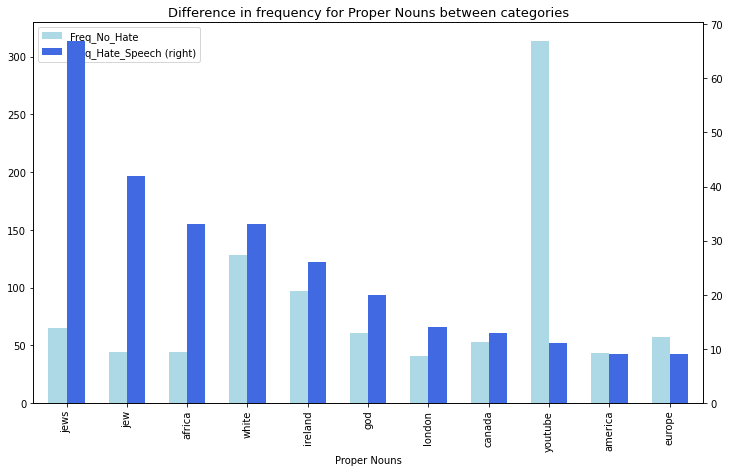

In [60]:
common_propn_df.set_index("Proper Nouns").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
#plt.grid(True)
plt.title('Difference in frequency for Proper Nouns between categories', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\Propn_tot_hate.png")
plt.show()

Difference in number of Proper Nouns is  0.02248551997162851


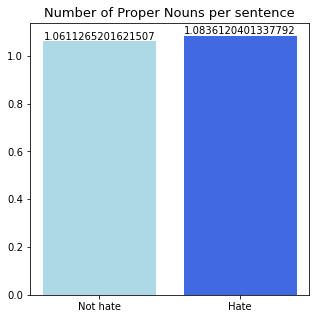

In [61]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (no_hate.PROPN_count.mean(), hate.PROPN_count.mean())
ax.bar("Not hate", no_hate.PROPN_count.mean(), color=['lightblue'], label='Not hate')
ax.bar("Hate", hate.PROPN_count.mean(), color=[ 'royalblue'], label='Hate')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Proper Nouns per sentence', fontsize = 13)
print('Difference in number of Proper Nouns is ', hate.PROPN_count.mean() - no_hate.PROPN_count.mean() )

## 3.3 Top Verbs

In [62]:
verb_counter_no = {}
for word in all_verbs_no_hate:
    if word in verb_counter_no:
        verb_counter_no[word] += 1
    else:
        verb_counter_no[word] = 1

top_20_verb_no = {k: v for k, v in sorted(verb_counter_no.items(), key=lambda item: item[1], reverse=True)[:20]}

In [63]:
verb_counter1 = {}
for word in all_verbs_hate:
    if word in verb_counter1:
        verb_counter1[word] += 1
    else:
        verb_counter1[word] = 1
            
top_20_verb1 = {k: v for k, v in sorted(verb_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

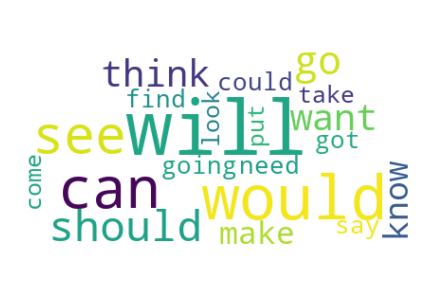

In [64]:
wc_v_hate = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_verb1)
plt.figure(figsize=(8,5))
plt.imshow(wc_v_hate, interpolation="bilinear")
plt.axis("off")
wc_v_hate.to_file("images_d\wc_v_hate.png")
plt.show()

In [65]:
top_verb = {"No_Hate": top_20_verb_no.keys(), "Freq_No_Hate": top_20_verb_no.values(), "Hate_Speech": top_20_verb1.keys(), "Freq_Hate": top_20_verb1.values()}
top_verb = pd.DataFrame(top_verb)
top_verb["R_Freq_No_Hate"] = top_verb.apply(lambda x: np.round(x.Freq_No_Hate / top_verb.Freq_No_Hate.sum(), 3), axis=1)
top_verb["R_Freq_Hate"] = top_verb.apply(lambda x: np.round(x.Freq_Hate / top_verb.Freq_Hate.sum(), 3), axis=1)
top_verb = top_verb.reindex(columns=['No_Hate', 'R_Freq_No_Hate', 'Hate_Speech', 'R_Freq_Hate'])
top_verb

,No_Hate,R_Freq_No_Hate,Hate_Speech,R_Freq_Hate
0,will,0.139,will,0.156
1,can,0.100,would,0.098
2,would,0.092,can,0.084
3,see,0.065,see,0.070
4,know,0.059,should,0.059
5,go,0.054,go,0.052
6,think,0.047,think,0.049
7,say,0.044,want,0.048
8,should,0.043,know,0.038
9,want,0.043,make,0.034


In [66]:
df_styled = top_verb
dfi.export(df_styled,"images_d/top_verb_df.jpg")

In [67]:
with open("serialized/top_verb_df.pkl", "wb") as f:
    pickle.dump(top_verb, f)

In [68]:
common_verb = list(set(top_verb["Hate_Speech"].values).intersection(set(top_verb["No_Hate"].values)))

In [69]:
freq_common_no_verb = [verb_counter_no[x] for x in common_verb]
freq_common_hate_verb = [verb_counter1[x] for x in common_verb]

In [70]:
common_verb_df = pd.DataFrame({"Verb" : common_verb, "Freq_No_Hate": freq_common_no_verb, "Freq_Hate_Speech": freq_common_hate_verb } )
common_verb_df = common_verb_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

In [71]:
with open("serialized/top20verb.pkl", "wb") as f:
    pickle.dump(common_verb_df, f)

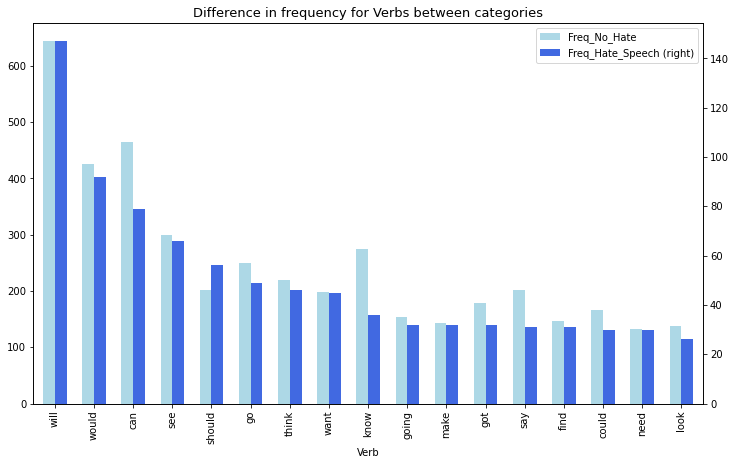

In [72]:
common_verb_df.set_index("Verb").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
#plt.grid(True)
plt.title('Difference in frequency for Verbs between categories', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\Verb_tot_hate.png")
plt.show()

Difference in number of Verbs is  1.1243450360457623


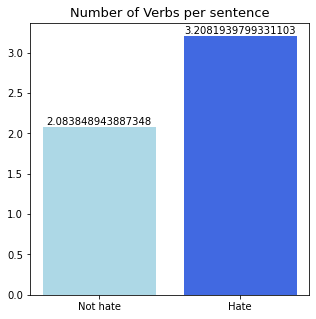

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (no_hate.VERB_count.mean(), hate.VERB_count.mean())
ax.bar("Not hate", no_hate.VERB_count.mean(), color=['lightblue'], label='Not hate')
ax.bar("Hate", hate.VERB_count.mean(), color=[ 'royalblue'], label='Hate')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Verbs per sentence', fontsize = 13)
print('Difference in number of Verbs is ', hate.VERB_count.mean() - no_hate.VERB_count.mean() )

In [ ]:
c1 = pd.Series([no_hate.ADJ_count.mean(),no_hate.NOUN_count.mean(), no_hate.PROPN_count.mean(), no_hate.VERB_count.mean()), index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])
                

In [103]:
c1 = pd.Series([no_hate.ADJ_count.mean(),no_hate.NOUN_count.mean(), no_hate.PROPN_count.mean(), no_hate.VERB_count.mean()], index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])
c2 = pd.Series([hate.ADJ_count.mean(), hate.NOUN_count.mean(), hate.PROPN_count.mean(), hate.VERB_count.mean()], index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])            
c3 = pd.Series([hate.ADJ_count.mean()-no_hate.ADJ_count.mean(), hate.NOUN_count.mean()-no_hate.NOUN_count.mean(), hate.PROPN_count.mean()-no_hate.PROPN_count.mean(), hate.VERB_count.mean()-no_hate.VERB_count.mean()], index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])            
d = {'No Hate Speech' : c1, 'Hate Speech': c2 , 'Difference' : c3}
diff_pos = pd.DataFrame(d)
diff_pos

,No Hate Speech,Hate Speech,Difference
Adjectives,1.233732,1.829431,0.595700
Nouns,2.810540,3.956522,1.145982
Proper Nouns,1.061127,1.083612,0.022486
Verbs,2.083849,3.208194,1.124345


In [105]:
df_styled = diff_pos
dfi.export(df_styled,"images_d/diff_pos_df.jpg")

In [104]:
with open("serialized/diff_pos.pkl", "wb") as f:
    pickle.dump(diff_pos, f)

### Cloud of top words

In [74]:
total = {**top_20_adj1 , **top_20_noun1, **top_20_propn1}

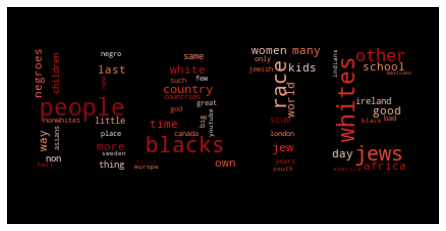

In [75]:
path = "C:/Users/marti/OneDrive - Università degli Studi di Milano/Desktop/Text mining before final version/images/hate5b.png"
mask = np.array(Image.open(path))
wordcloud = WordCloud(width=5000, height=400, colormap="Reds", background_color="black", mask=mask).generate_from_frequencies(total)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
figsize=(10,8)
wordcloud.to_file("images_d\wc_tot_hate.png")
plt.show()

## 4. Sentiment Analysis by VADER 

In [76]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [77]:
sia = vd.SentimentIntensityAnalyzer()
pos_list = ["NOUN", "VERB", "DET", "ADP", "ADJ" ]
data["NOUN_VERB_DET_ADP_ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_VERB_DET_ADP_ADJ'] = data["NOUN_VERB_DET_ADP_ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_VERB_DET_ADP_ADJ']
correl_NOUN_VERB_DET_ADP_ADJ = col1.corr(col2)
print(correl_NOUN_VERB_DET_ADP_ADJ)
print(data['sentiment_NOUN_VERB_DET_ADP_ADJ'].mean())

-0.1345571236474063
0.007913822138126641


In [78]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP", "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET']
correl_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET)
print(data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET'].mean())

-0.13406183240476716
0.021060350047303784


In [79]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV",  "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_DET'] = data["NOUN_PROPN_VERB_ADJ_ADV_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_DET']
correl_NOUN_PROPN_VERB_ADJ_ADV_DET = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_DET)
print(data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_DET'].mean())

-0.13391474909642492
0.020841229895931977


In [80]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP']
correl_NOUN_PROPN_VERB_ADJ_ADV_ADP = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_ADP)
print(data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP'].mean())

-0.12969309956905445
0.030693651844844117


In [81]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV" ]
data["NOUN_PROPN_VERB_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV'] = data["NOUN_PROPN_VERB_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV']
correl_NOUN_PROPN_VERB_ADJ_ADV = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV)
print(data['sentiment_NOUN_PROPN_VERB_ADJ_ADV'].mean())

-0.12955040688521188
0.03047453169347231


In [82]:
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)
print(data['sentiment_text'].mean())

-0.12328124218885073
0.05559022705771056


In [83]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "SCONJ"]
data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_SCONJ'] = data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_SCONJ']
correl_NOUN_PROPN_VERB_ADJ_ADV_SCONJ = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_SCONJ)
print(data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_SCONJ'].mean())

-0.12064447028606412
0.05026022705771072


In [84]:
pos_list = ["NOUN","PROPN", "ADJ", "ADV" ]
data["NOUN_PROPN_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_ADJ_ADV'] = data["NOUN_PROPN_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_ADJ_ADV']
correl_NOUN_PROPN_ADJ_ADV = col1.corr(col2)
print(correl_NOUN_PROPN_ADJ_ADV)
print(data['sentiment_NOUN_PROPN_ADJ_ADV'].mean())

-0.10994786289813493
0.028547284768211997


In [85]:
pos_list = ["NOUN","PROPN", "ADJ" ]
data["NOUN_PROPN_ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_ADJ'] = data["NOUN_PROPN_ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_ADJ']
correl_NOUN_PROPN_ADJ = col1.corr(col2)
print(correl_NOUN_PROPN_ADJ)
print(data['sentiment_NOUN_PROPN_ADJ'].mean())

-0.10955694069320285
0.018418297067171237


In [86]:
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)
print(data['sentiment_ADJ'].mean())

-0.08579024709360271
0.04119945127719986


In [87]:
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)
print(data['sentiment_VERB'].mean())

-0.08221487852960037
0.0019272469252601808


In [88]:
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)
print(data['sentiment_NOUN'].mean())

-0.07673258352489348
-0.025798694418164698


In [89]:
pos_list = ["DET"]
data["DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_DET'] = data["DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_DET']
correl_DET = col1.corr(col2)
print(correl_DET)
print(data['sentiment_DET'].mean())

-0.052735370519527765
-0.009633301797540274


In [90]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)
print(data['sentiment_PROPN'].mean())

-0.016940121253982872
0.0030175402081362326


In [91]:
data['sentiment_ADV'] = data["ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADV']
correl_ADV = col1.corr(col2)
print(correl_ADV)
print(data['sentiment_ADV'].mean())

-0.016532715203977234
0.010128987701040672


In [92]:
pos_list = ["ADP"]
data["ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADP'] = data["ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADP']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)
print(data['sentiment_ADP'].mean())

-0.00908902676846732
0.00021912015137180702


In [93]:
data['sentiment_PRON'] = data["PRON"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PRON']
correl_PRON = col1.corr(col2)
print(correl_PRON)
print(data['sentiment_PRON'].mean())

-0.0034744508004525537
2.140964995269631e-05


In [94]:
data['sentiment_SCONJ'] = data["SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_SCONJ']
correl_SCONJ = col1.corr(col2)
print(correl_SCONJ)
print(data['sentiment_SCONJ'].mean())

0.04782244182932744
0.01978569536423826
